Valentine Shilov
# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 мая 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 мая, -4 балла после 06:00 13 мая, -6 баллов после 06:00 20 мая -8 баллов  после 06:00 27 мая


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***
$$
V = \sum_{i=1}^{N} \sum_{k=1}^K r_{ki} \lVert x_k - \mu_{i} \rVert ^{2}
$$
Частный случай EM - алгоритма
На итерации j:

1) шаг E:
$$
V_{j}^E = \min_{S}V_{j}
$$
2) шаг M:
$$
V_{j}^M = \min_{\mu}V_{j}
$$
$S$ - множество распределений объектов по кластерам.
$V_{j}$ - ограниченная, монотонная последовательность => сходиться
Алгоритм заканчивается когда после итерации не происходит изменения распределения объектов по классам.
Вариантов распределений $k^N$, $V_{j}$  - монотонная => алгоритм завершится через <=$k^N$  итераций

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***решение***
функция правдободобия ограничена сверху

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***решение ***

$d_{\max}(U \cup V, S)=\max(d_{\max}(U, S),d_{\max}(V, S))$
$=\frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |$
$d_{\min}(U \cup V, S)=\min(d_{\min}(U, S),d_{\min}(V, S))$
$=\frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |$

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin
import scipy.cluster.hierarchy as sch
import copy
from scipy.spatial import distance

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, n_clusters=2, metric='euclidean',linkage='single', **kwargs):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        self.n_clusters=n_clusters
        self.metric=metric
        m = {\
            'euclidean' : distance.euclidean,\
            'cosine' : distance.cosine,\
            'manhattan' : distance.cityblock,\
            'minkowski' : distance.minkowski,\
            'l2' : distance.euclidean,\
            'l1': distance.cityblock,\
             'your_favourite_metric' : distance.minkowski,\
             'precomputed' : "not a function"
            
        }
       
        self.linkage=linkage
        self.dist = m[metric]
        
        if linkage=='complete':
            self.c=1/2
            self.a_i=1/2
            self.a_j=1/2
            
        elif linkage=='single':
            self.c=-1/2
            self.a_i=1/2
            self.a_j=1/2
            
        elif linkage=='average':
            self.c=0
        
        return
        
    def fit_predict(self, x, dist_matrix = None):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        self.x_len = len(x)
        preds = pred_iris = [ 0 ] * self.x_len
        
        if type(self.dist) == type("adsad"):
            distance_matrix = dist_matrix
        else:
            distance_matrix = smt.pairwise_distances(x, metric=self.dist)
        
        #i=j
        distance_matrix[np.arange(self.x_len), np.arange(self.x_len)] = np.inf
        
        current_classes = [np.array([i]) for i in range(self.x_len)]
        i_classes = []
        i_classes.append(copy.deepcopy(current_classes))
        lm = np.empty((self.x_len, 4))
        class_numbers = np.arange(self.x_len)
        n_classes = self.x_len
        for i in np.arange(1, self.x_len):
            classes_merging = np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)
            min_index, max_index = min(classes_merging), max(classes_merging)
            lm[i, 0] = class_numbers[min_index]
            lm[i, 1] = class_numbers[max_index]
            lm[i, 2] = distance_matrix[classes_merging]
            class_numbers[min_index] = n_classes
            
            i_distance = np.append(distance_matrix[:min_index, min_index], distance_matrix[min_index, min_index + 1:])
            j_distance = np.append(distance_matrix[:max_index, max_index], distance_matrix[max_index, max_index + 1:])
            dist_update = self.a_j * j_distance + self.a_i * i_distance  + self.c * np.abs(i_distance - j_distance)           
            distance_matrix[:min_index, min_index] = dist_update[:min_index]
            distance_matrix[min_index, min_index + 1:] = dist_update[min_index:]
            distance_matrix = np.delete(np.delete(distance_matrix, max_index, 1), max_index, 0)

            class_numbers = np.delete(class_numbers, max_index, 0)
            next_classes = np.append(current_classes[min_index], current_classes[max_index], axis=0)
            current_classes[min_index] = next_classes
            current_classes.pop(max_index)
            lm[i, 3] = next_classes.size
            
            i_classes.append(copy.deepcopy(current_classes))
            n_classes += 1
        
        
        ri = i_classes[-self.n_clusters]
        preds = np.empty(self.x_len, dtype=np.int)
        for i in range(self.n_clusters):
            preds[ri[i]] = i
        
        self.lm = lm[1:]
        return preds
    
    def plot_dendrogram(self):
        """
        Try to visualize our data
        """
        plt.figure(figsize=(15, 15))
        sch.dendrogram(self.lm)
        

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

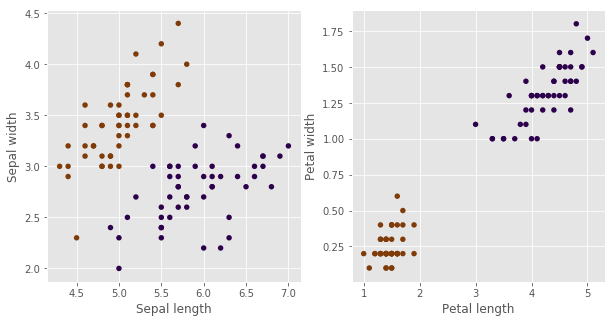

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [4]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.0041921138763427734


In [5]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(metric='your_favourite_metric')
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 0.1849963665008545


# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? Как еще учесть другую информацию о странице в расстоянии?

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках. В семинаре мы рассматривали более сложный вариант, но Вы сможете придумать лучше. 

In [6]:
doc_to_title = {}
with open('../class/docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [7]:
train_data = pd.read_csv('../class/train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять например словами из тайтла

Главное подобрать хорошую функцию расстояния между документами

Удачи! Все получится!

Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [8]:
def dist(x, y):
    return 1.0 - (len(x.intersection(y)) / (len(x) + len(y)))

def tittleToWords(tittle, morph):
    words = set()
    
    text = tittle.lower()
    symbols = ",.()!><?\r\n:;`~@*&^%${}[]-+/\\«»"
    for s in symbols:
         text=text.replace(s, " ")

    symbols = "\xad"
    for s in symbols:
         text=text.replace(s, " ")

    for i in range(120):
        text=text.replace("  ", " ")

    we = str(text).strip(' ')
    we = str(text).split(' ')
    
    for word in we:
        ww = word.strip()
        p = morph.parse(ww)
        if(len(p)>=1):
            ww = p[0].normal_form
        words.add(ww)
    return words

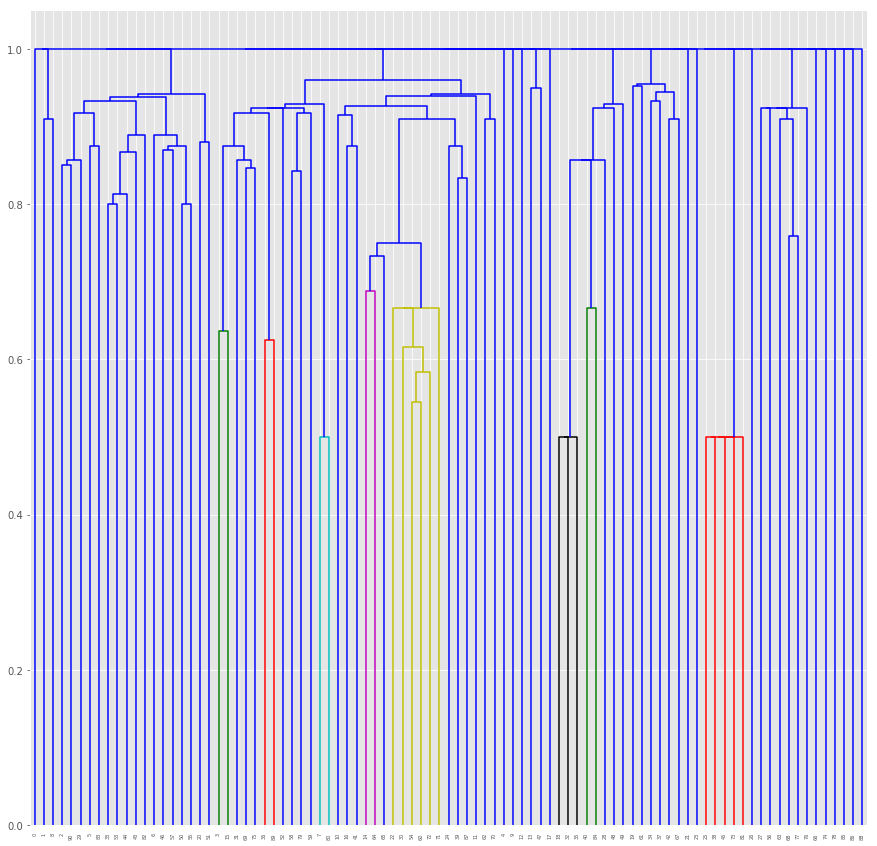

In [9]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
y_train = []
X_train = []
y_pred = np.empty(0)
clf = Clustering(n_clusters=2, metric='precomputed', linkage='complete')
for group in traingroups_titledata:
    X_train = []
    docs = traingroups_titledata[group]
    for (doc_id, title, target_id) in docs:
        y_train.append(target_id)
        words = tittleToWords(title.strip(), morph)
        X_train.append(words)
    distance_matrix = np.empty((len(X_train), len(X_train)))
    for i in range(len(X_train)):
        for j in range(len(X_train)):
            distance_matrix[i][j] = dist(X_train[i], X_train[j])
        
    y_pred_g = clf.fit_predict(np.array(X_train), distance_matrix)
    y_pred = np.append(y_pred, y_pred_g)

clf.plot_dendrogram()

In [10]:
from sklearn.metrics import f1_score

print(f1_score(np.logical_not(y_pred), y_train))

0.4451174372434215


Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ваше ответ здесь***
В задачах выявления групп похожих элементов
При построении систем рекомендации


* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ваше ответ здесь***

kmeans:

+простота

-необходимо знать заранее число кластеров

-зависимость результата от начальных координат центров кластеров

-плохо устойчив к выбросам

dbscan:

+не надо знать заранее число кластеров

+устойчив в выбросам

-плохо работает при разных плотностях кластеров

агломеративная:

+простота

-нужно стрить матрицу расстояний - проблемы при большом количестве объектов: O(N^2) по памяти

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ваше ответ здесь***
Когда мало данных, или невозможно построить функционал правдоподобия

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ваше ответ здесь***
В начале нужно было провести препроцесинг текстов - привести слова к нормальной ворме, удалить предлоги и не енсущие смысла слова, ....
Признаки - нормированное количество общих слов (с учётом IDF), ...

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ваше ответ здесь***
Да
Например, если использовать KMeans, то можно выбрать начальные центры кластеров в центрах размеченных групп

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***